In [8]:
import pandas as pd
import numpy as np
from scipy.stats import norm, multinomial
import matplotlib.pyplot as plt


In [6]:
def state_transition(previous_state, noise_std=0.1):
    k, beta = previous_state
    k_new = np.clip(k + np.random.normal(0, noise_std), 1, 10)  # 假设k的范围是1-10
    beta_new = np.clip(beta + np.random.normal(0, noise_std), 0.01, 10)  # beta要保持正数
    return np.array([k_new, beta_new])

def observation_model(state, features, choice):
    k, beta = state
    k = int(round(k))  # 将k四舍五入为整数
    
    # 假设特征的重要性是均等的
    feature_weights = np.ones(4) / 4
    
    # 计算每个类别的原型（这里假设只有两个类别）
    prototype1 = np.array([0.25, 0.25, 0.25, 0.25])  # 类别1的原型
    prototype2 = np.array([0.75, 0.75, 0.75, 0.75])  # 类别2的原型
    
    # 计算刺激与原型的距离
    distance1 = np.sum(feature_weights * (features - prototype1)**2)
    distance2 = np.sum(feature_weights * (features - prototype2)**2)
    
    # 计算选择每个类别的概率
    p1 = np.exp(-distance1 / beta)
    p2 = np.exp(-distance2 / beta)
    p_total = p1 + p2
    
    prob_choice1 = p1 / p_total
    prob_choice2 = p2 / p_total
    
    # 返回实际选择的概率
    return prob_choice1 if choice == 1 else prob_choice2

def particle_filter(subject_data, n_particles=1000):
    n_trials = len(subject_data)
    particles = np.zeros((n_particles, 2, n_trials))
    weights = np.ones(n_particles) / n_particles

    # 初始化粒子
    particles[:, 0, 0] = np.random.uniform(1, 10, n_particles)  # k
    particles[:, 1, 0] = np.random.uniform(0.01, 10, n_particles)  # beta

    estimated_states = np.zeros((2, n_trials))

    for t in range(n_trials):
        features = subject_data.iloc[t][['feature1', 'feature2', 'feature3', 'feature4']].values
        choice = subject_data.iloc[t]['choice']

        if t > 0:
            # 预测步骤
            particles[:, :, t] = np.array([state_transition(p) for p in particles[:, :, t-1]])

        # 更新步骤
        for i in range(n_particles):
            prob = observation_model(particles[i, :, t], features, choice)
            weights[i] *= prob

        # 归一化权重
        weights += 1e-300  # 防止权重为0
        weights /= weights.sum()

        # 重采样
        if 1 / (weights ** 2).sum() < n_particles / 2:
            indices = np.random.choice(n_particles, n_particles, p=weights)
            particles[:, :, t] = particles[indices, :, t]
            weights = np.ones(n_particles) / n_particles

        # 估计当前状态
        estimated_states[:, t] = np.average(particles[:, :, t], weights=weights, axis=0)

    return estimated_states

def plot_dynamic_parameters(estimated_states, n_trials):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    trials = np.arange(1, n_trials + 1)

    ax1.plot(trials, estimated_states[0, :], '-o')
    ax1.set_ylabel('Estimated k')
    ax1.set_title('Dynamic k values over trials')

    ax2.plot(trials, estimated_states[1, :], '-o')
    ax2.set_ylabel('Estimated beta')
    ax2.set_xlabel('Trial')
    ax2.set_title('Dynamic beta values over trials')

    plt.tight_layout()
    plt.show()

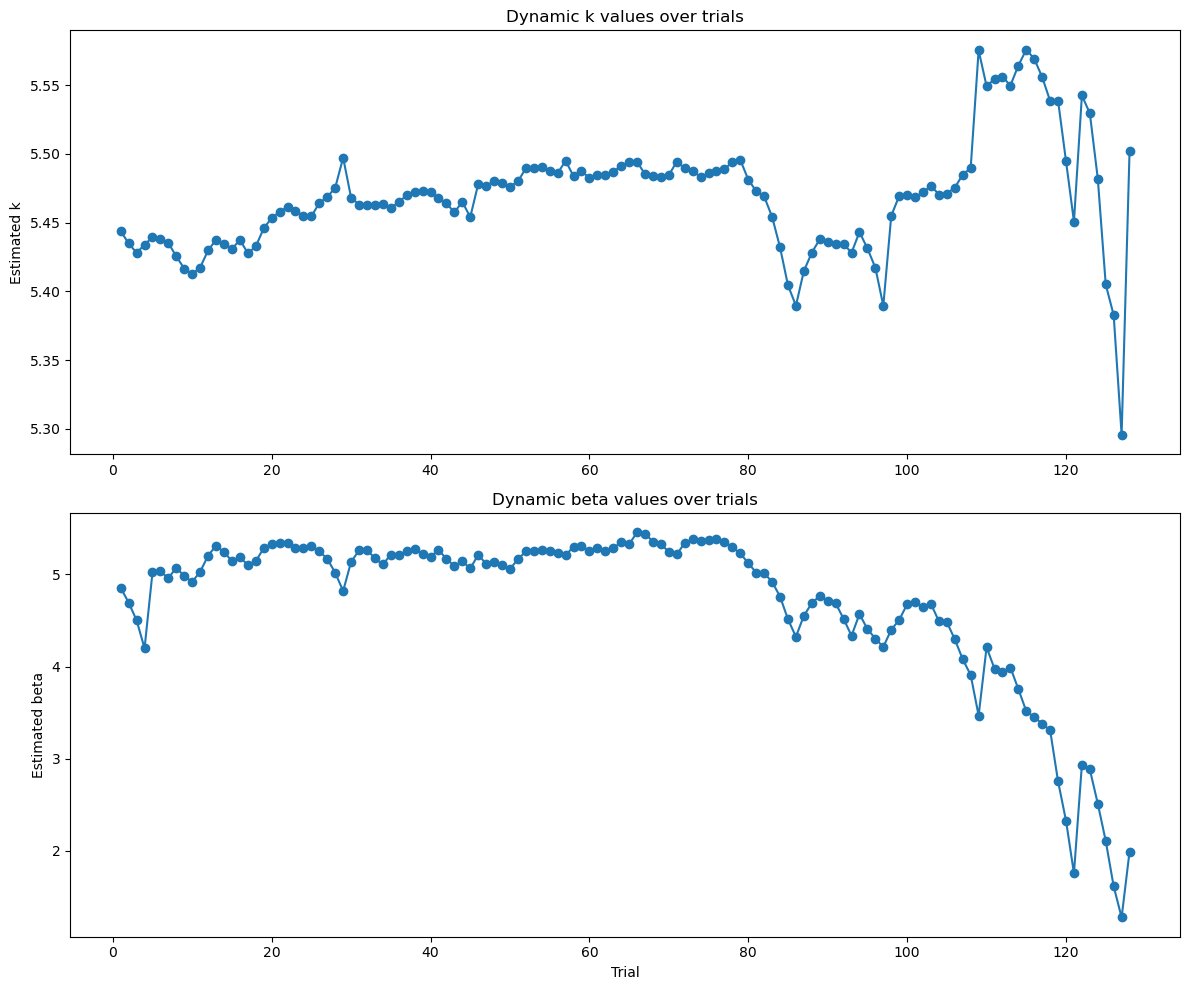

Finished processing subject 1


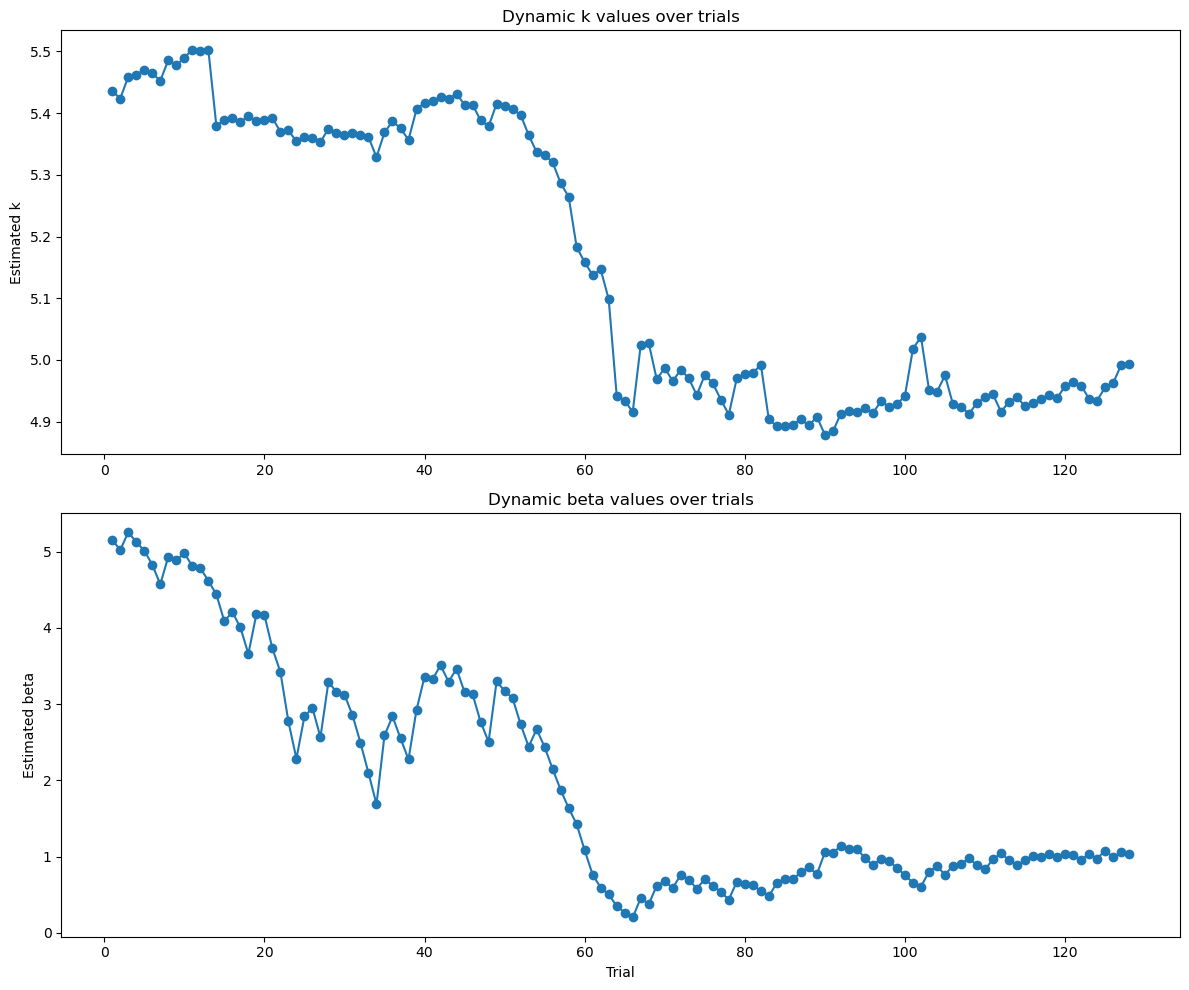

Finished processing subject 4


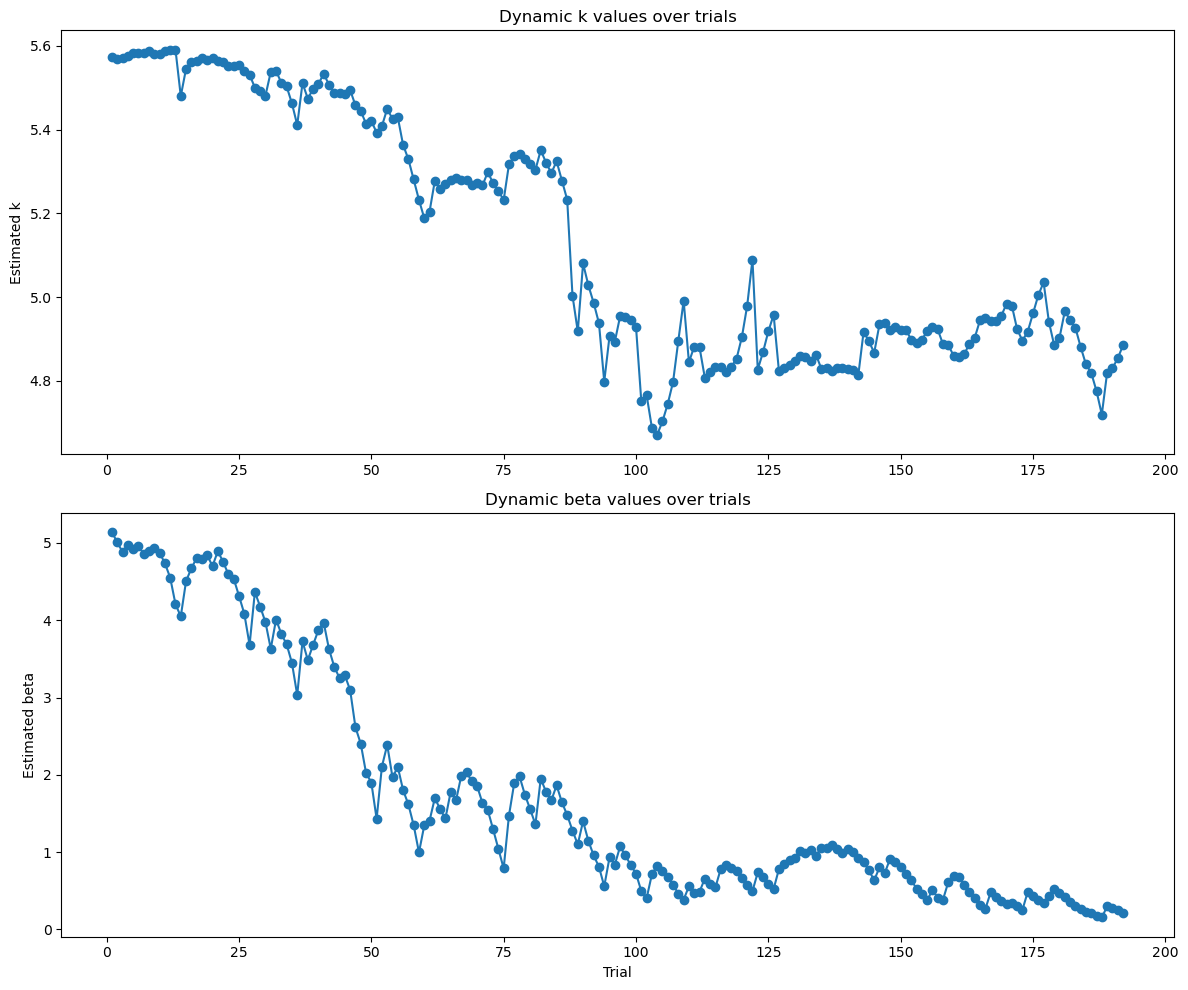

Finished processing subject 6


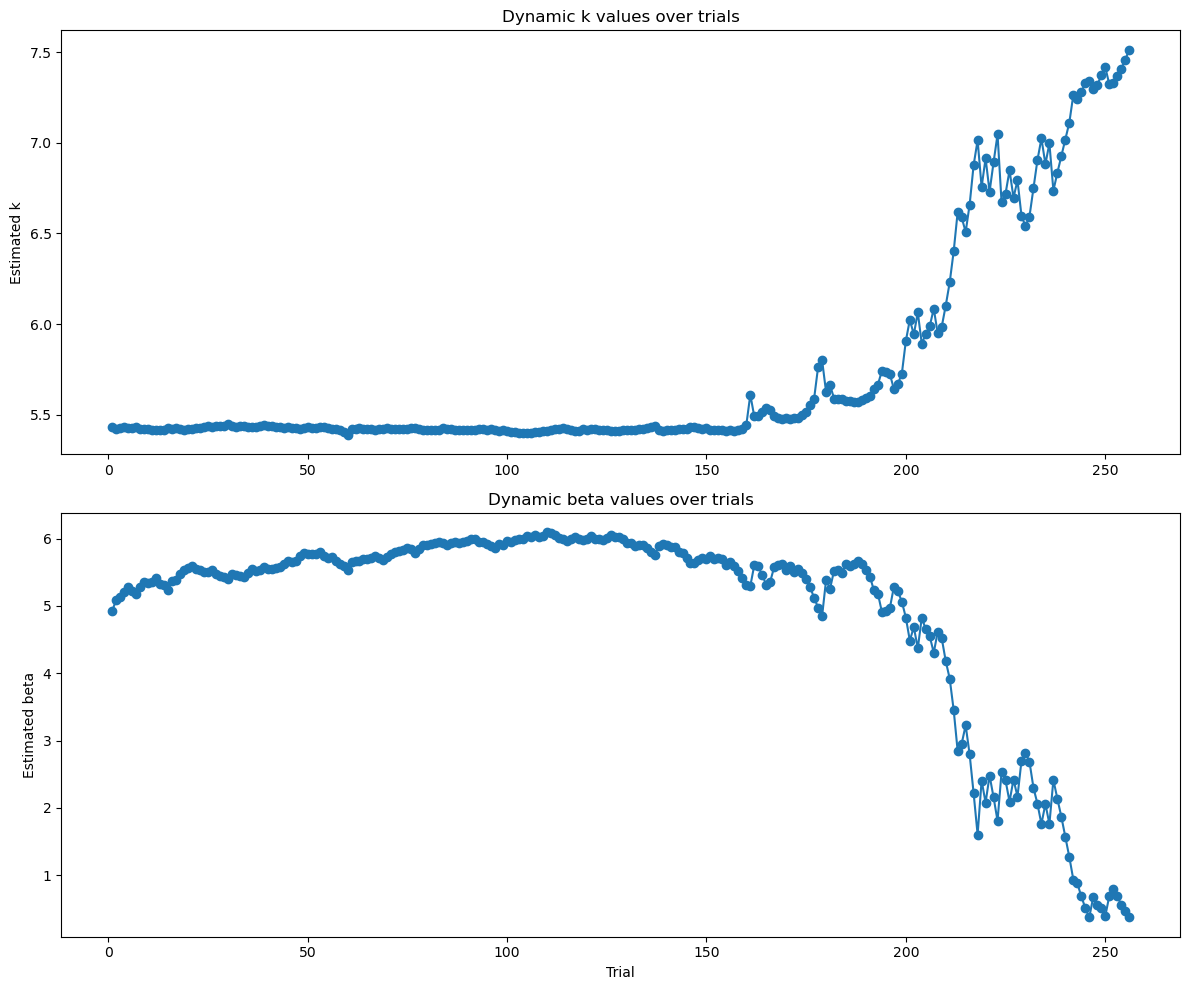

Finished processing subject 11


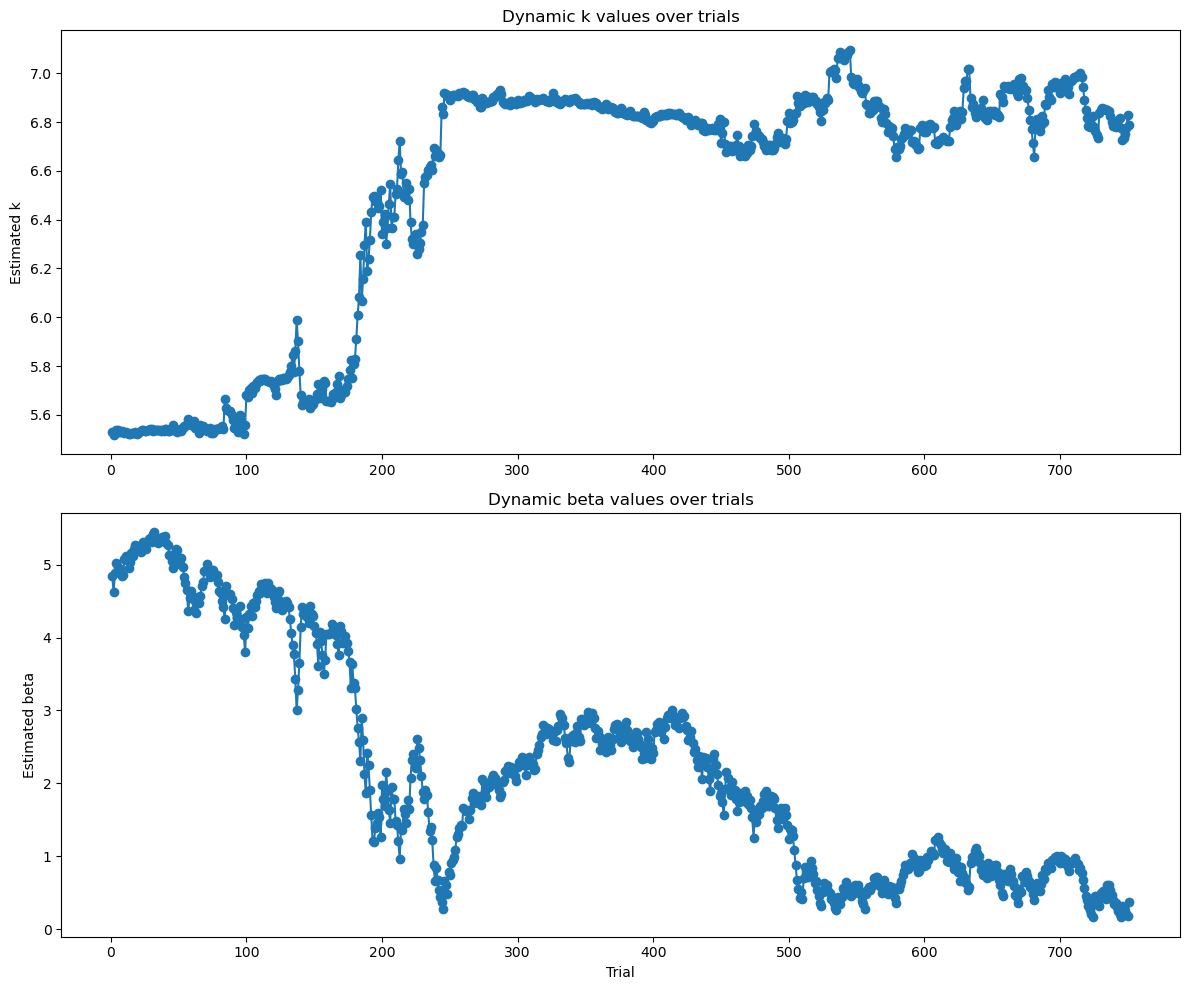

Finished processing subject 21


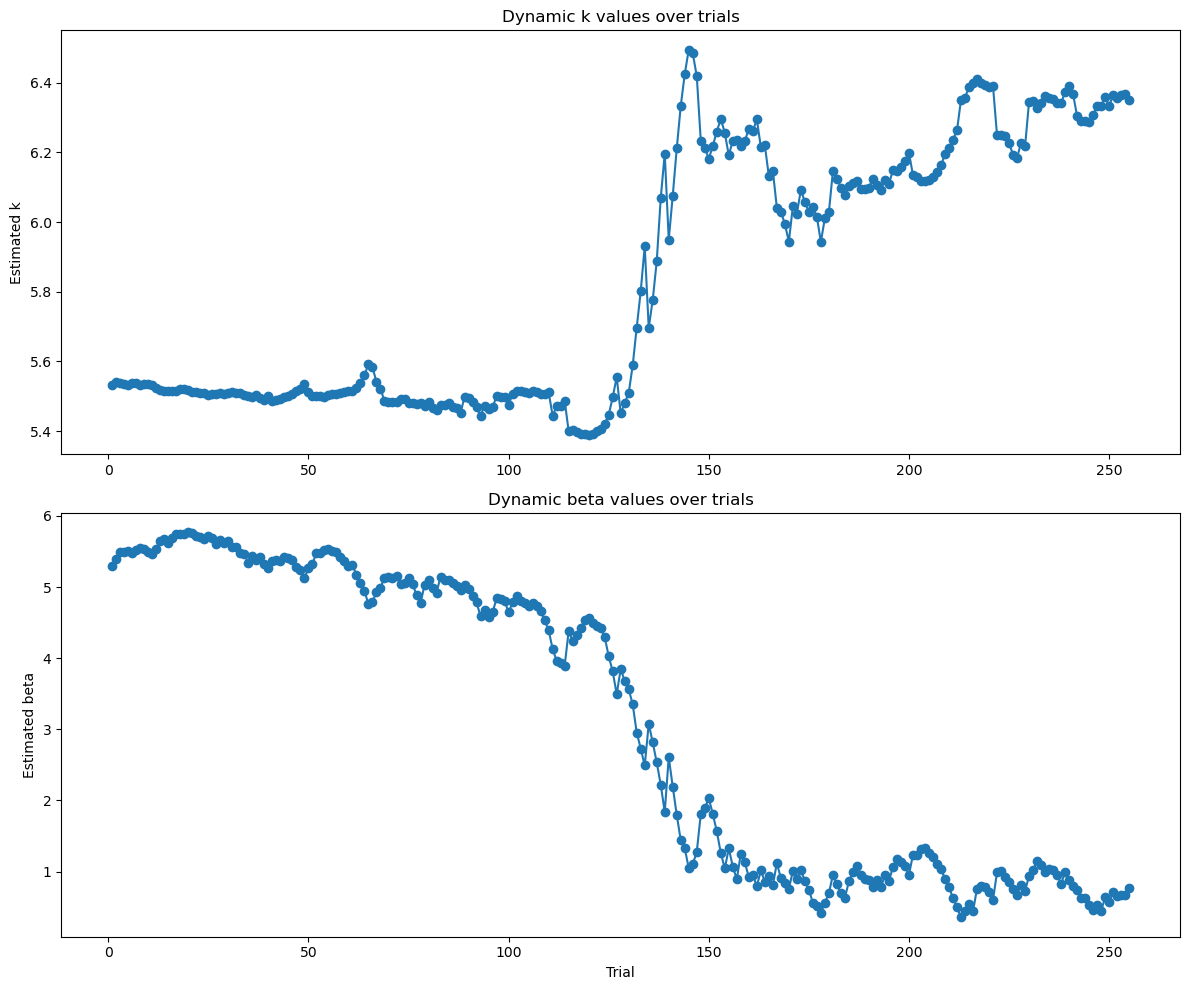

Finished processing subject 26


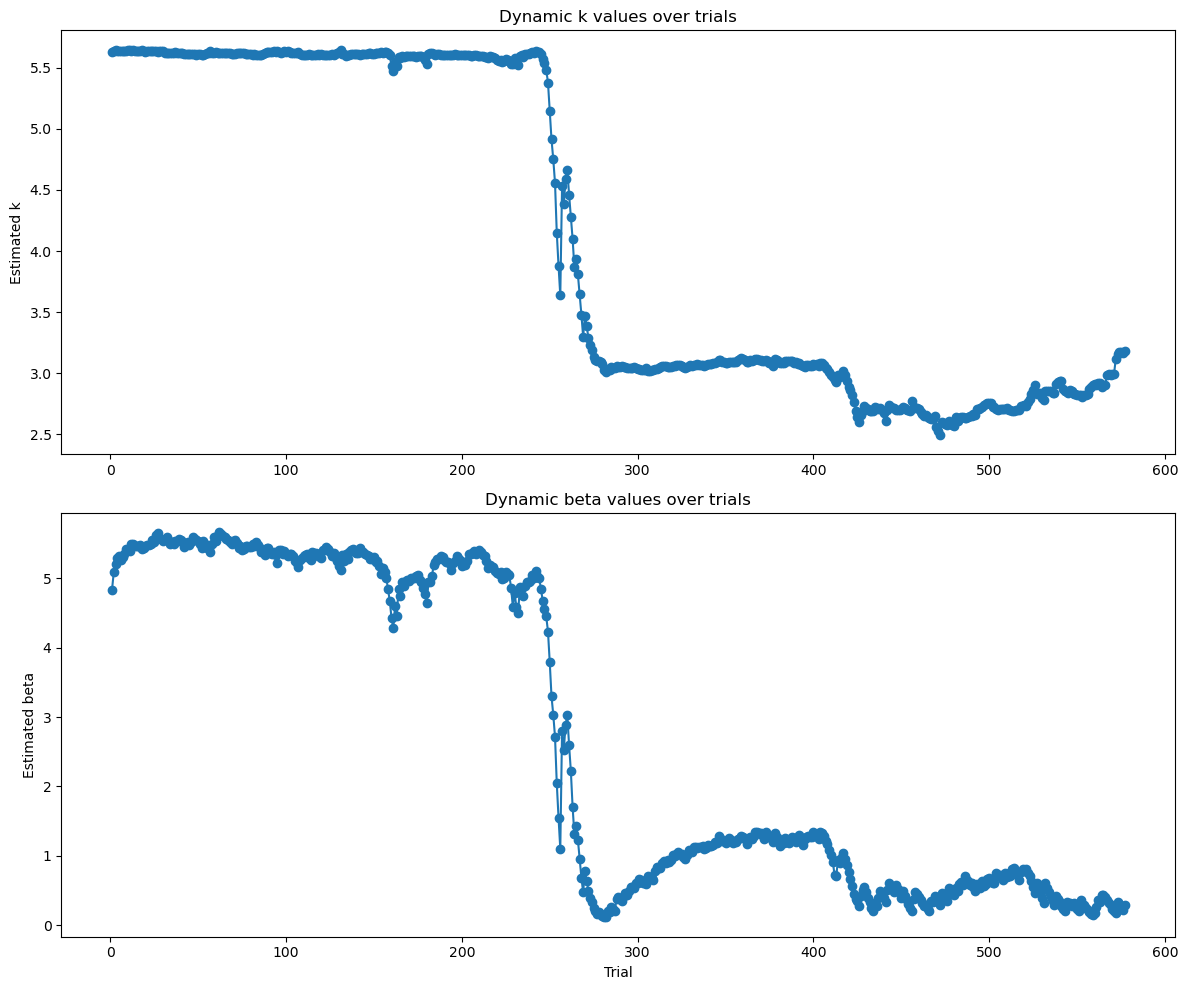

Finished processing subject 27


In [9]:
data = pd.read_csv('Task2.csv')

# 对每个被试进行分析
for subject in data['iSub'].unique():
    subject_data = data[data['iSub'] == subject]
    estimated_states = particle_filter(subject_data)
    plot_dynamic_parameters(estimated_states, len(subject_data))
    print(f"Finished processing subject {subject}")